In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from sklearn import utils
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler

import base
import cvae_torch
from importlib import reload
reload(cvae_torch)

<module 'cvae_torch' from '../src\\cvae_torch.py'>

In [11]:
import datetime
import numpy as np
import pandas_datareader as pdr
import esig
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import base
from utils import tosig
from utils.leadlag import leadlag
from rough_bergomi import rough_bergomi

from importlib import reload
import cvae_keras
reload(cvae_keras)
import cvae_tfp
reload(cvae_tfp)

import matplotlib.pyplot as plt

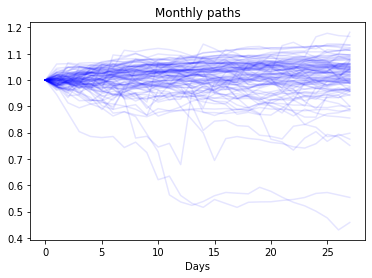

In [12]:
# Actually for rough_bergomi model, conditional VAE does no help because the cond are independent

# rough_bergomi
params = {
            "M": 100,
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.1,
            "nu": 1.5,
            "S0": 1.
          }

def _load_rough_bergomi(params, test_use = False):
    grid_points_dict = {"M": 28, "W": 5, "Y": 252}
    grid_points = grid_points_dict['M']
    params["T"] = grid_points / grid_points_dict["Y"]
    paths = rough_bergomi(grid_points, **params)
    if test_use:
        windows = paths
    else:   
        windows = [leadlag(path) for path in paths]
    return windows

windows = _load_rough_bergomi(params)

for path in windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.1)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

In [14]:
order = 4
def _logsig(path):
    return esig.tosig.stream2logsig(path, order)
def _sig(path):
    return esig.tosig.stream2sig(path, order)

train_windows = _load_rough_bergomi(params)
train_logsig = np.array([_logsig(path) for path in tqdm(train_windows, desc="Computing log-signatures")])
train_sig = np.array([_sig(path) for path in tqdm(train_windows, desc="Computing signatures")])

test_windows = _load_rough_bergomi(params)
test_logsig = np.array([_logsig(path) for path in tqdm(test_windows, desc="Computing log-signatures")])
test_sig = np.array([_sig(path) for path in tqdm(test_windows, desc="Computing signatures")])

scaler_logsig = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig_transformed = scaler_logsig.fit_transform(train_logsig)

scaler_sig = MinMaxScaler(feature_range=(0.00001, 0.99999))
sig_transformed = scaler_sig.fit_transform(train_sig)

data = logsig_transformed[1:]   # 1 week forecasting 1 week 
data_cond = logsig_transformed[:-1] 
scaler = scaler_logsig

# data = sig_transformed[1:]   # 1 week forecasting 1 week 
# data_cond = sig_transformed[:-1] 
# scaler = scaler_sig

In [15]:
# Torch
reload(cvae_torch)
BATCH_SIZE = data.shape[0]         # number of data points in each batch
INPUT_DIM = data.shape[-1]     # size of each input
HIDDEN_DIM = 50        # hidden dimension   50
LATENT_DIM = 8         # latent vector dimension   8
CONDITION_DIM = data_cond.shape[-1]      # condition dim
BETA = 0.005
train_iterator, test_iterator = cvae_torch.data_pepare(data,data_cond, None,BATCH_SIZE)
model = cvae_torch.CVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, CONDITION_DIM, BETA)
model.prepare(train_iterator, test_iterator)

In [16]:
model.train_all(1000)

Epoch 0, Train Loss: 1.08839, Test Loss: 1.03570
Epoch 1, Train Loss: 1.04069, Test Loss: 1.00854
Epoch 2, Train Loss: 1.00678, Test Loss: 0.98515
Epoch 3, Train Loss: 0.98122, Test Loss: 0.95388
Epoch 4, Train Loss: 0.92349, Test Loss: 0.91326
Epoch 5, Train Loss: 0.92976, Test Loss: 0.89708
Epoch 6, Train Loss: 0.88864, Test Loss: 0.88338
Epoch 7, Train Loss: 0.86517, Test Loss: 0.81585
Epoch 8, Train Loss: 0.82899, Test Loss: 0.80410
Epoch 9, Train Loss: 0.79636, Test Loss: 0.78683
Epoch 10, Train Loss: 0.76053, Test Loss: 0.75360
Epoch 11, Train Loss: 0.74415, Test Loss: 0.68547
Epoch 12, Train Loss: 0.71901, Test Loss: 0.70074
Epoch 13, Train Loss: 0.69459, Test Loss: 0.65771
Epoch 14, Train Loss: 0.65779, Test Loss: 0.66178
Epoch 15, Train Loss: 0.63623, Test Loss: 0.60233
Epoch 16, Train Loss: 0.60232, Test Loss: 0.56871
Epoch 17, Train Loss: 0.57175, Test Loss: 0.55619
Epoch 18, Train Loss: 0.56465, Test Loss: 0.54354
Epoch 19, Train Loss: 0.57270, Test Loss: 0.50589
Epoch 20, 

Epoch 196, Train Loss: 0.12750, Test Loss: 0.11111
Epoch 197, Train Loss: 0.11702, Test Loss: 0.11930
Epoch 198, Train Loss: 0.10611, Test Loss: 0.10599
Epoch 199, Train Loss: 0.12116, Test Loss: 0.10762
Epoch 200, Train Loss: 0.10897, Test Loss: 0.10316
Epoch 201, Train Loss: 0.11823, Test Loss: 0.10946
Epoch 202, Train Loss: 0.12228, Test Loss: 0.11054
Epoch 203, Train Loss: 0.10793, Test Loss: 0.12072
Epoch 204, Train Loss: 0.10052, Test Loss: 0.12568
Epoch 205, Train Loss: 0.10537, Test Loss: 0.09884
Epoch 206, Train Loss: 0.10347, Test Loss: 0.10552
Epoch 207, Train Loss: 0.12061, Test Loss: 0.11795
Epoch 208, Train Loss: 0.11181, Test Loss: 0.10982
Epoch 209, Train Loss: 0.11653, Test Loss: 0.12147
Epoch 210, Train Loss: 0.10456, Test Loss: 0.10554
Epoch 211, Train Loss: 0.10128, Test Loss: 0.09623
Epoch 212, Train Loss: 0.11086, Test Loss: 0.11144
Epoch 213, Train Loss: 0.11271, Test Loss: 0.10284
Epoch 214, Train Loss: 0.11065, Test Loss: 0.11123
Epoch 215, Train Loss: 0.10890,

Epoch 392, Train Loss: 0.05784, Test Loss: 0.05384
Epoch 393, Train Loss: 0.06070, Test Loss: 0.05548
Epoch 394, Train Loss: 0.05316, Test Loss: 0.05784
Epoch 395, Train Loss: 0.05464, Test Loss: 0.05766
Epoch 396, Train Loss: 0.05998, Test Loss: 0.05589
Epoch 397, Train Loss: 0.05661, Test Loss: 0.05108
Epoch 398, Train Loss: 0.05713, Test Loss: 0.05100
Epoch 399, Train Loss: 0.05716, Test Loss: 0.05781
Epoch 400, Train Loss: 0.05145, Test Loss: 0.05468
Epoch 401, Train Loss: 0.05497, Test Loss: 0.05672
Epoch 402, Train Loss: 0.06016, Test Loss: 0.05323
Epoch 403, Train Loss: 0.05584, Test Loss: 0.05458
Epoch 404, Train Loss: 0.05685, Test Loss: 0.05405
Epoch 405, Train Loss: 0.05327, Test Loss: 0.05281
Epoch 406, Train Loss: 0.05370, Test Loss: 0.05320
Epoch 407, Train Loss: 0.05559, Test Loss: 0.05793
Epoch 408, Train Loss: 0.05527, Test Loss: 0.05065
Epoch 409, Train Loss: 0.05317, Test Loss: 0.05634
Epoch 410, Train Loss: 0.05559, Test Loss: 0.05334
Epoch 411, Train Loss: 0.05362,

Epoch 565, Train Loss: 0.04237, Test Loss: 0.04245
Epoch 566, Train Loss: 0.04483, Test Loss: 0.04606
Epoch 567, Train Loss: 0.04491, Test Loss: 0.04584
Epoch 568, Train Loss: 0.04481, Test Loss: 0.04691
Epoch 569, Train Loss: 0.04665, Test Loss: 0.04692
Epoch 570, Train Loss: 0.04337, Test Loss: 0.04842
Epoch 571, Train Loss: 0.04336, Test Loss: 0.04348
Epoch 572, Train Loss: 0.04443, Test Loss: 0.04417
Epoch 573, Train Loss: 0.04484, Test Loss: 0.04324
Epoch 574, Train Loss: 0.04519, Test Loss: 0.04581
Epoch 575, Train Loss: 0.04648, Test Loss: 0.04203
Epoch 576, Train Loss: 0.04596, Test Loss: 0.04243
Epoch 577, Train Loss: 0.04226, Test Loss: 0.04234
Epoch 578, Train Loss: 0.04375, Test Loss: 0.04289
Epoch 579, Train Loss: 0.04167, Test Loss: 0.04453
Epoch 580, Train Loss: 0.04629, Test Loss: 0.04608
Epoch 581, Train Loss: 0.04377, Test Loss: 0.04253
Epoch 582, Train Loss: 0.04495, Test Loss: 0.04307
Epoch 583, Train Loss: 0.04324, Test Loss: 0.04484
Epoch 584, Train Loss: 0.04265,

Epoch 759, Train Loss: 0.03843, Test Loss: 0.03780
Epoch 760, Train Loss: 0.03781, Test Loss: 0.03831
Epoch 761, Train Loss: 0.03640, Test Loss: 0.03890
Epoch 762, Train Loss: 0.03710, Test Loss: 0.03864
Epoch 763, Train Loss: 0.03902, Test Loss: 0.03705
Epoch 764, Train Loss: 0.03767, Test Loss: 0.03925
Epoch 765, Train Loss: 0.03994, Test Loss: 0.03992
Epoch 766, Train Loss: 0.03796, Test Loss: 0.03730
Epoch 767, Train Loss: 0.03629, Test Loss: 0.03754
Epoch 768, Train Loss: 0.04087, Test Loss: 0.03873
Epoch 769, Train Loss: 0.03768, Test Loss: 0.03711
Epoch 770, Train Loss: 0.03854, Test Loss: 0.03650
Epoch 771, Train Loss: 0.03633, Test Loss: 0.03712
Epoch 772, Train Loss: 0.03811, Test Loss: 0.04320
Epoch 773, Train Loss: 0.03765, Test Loss: 0.03869
Epoch 774, Train Loss: 0.03896, Test Loss: 0.03657
Epoch 775, Train Loss: 0.03810, Test Loss: 0.03569
Epoch 776, Train Loss: 0.03643, Test Loss: 0.03699
Epoch 777, Train Loss: 0.03781, Test Loss: 0.03860
Epoch 778, Train Loss: 0.03673,

Epoch 923, Train Loss: 0.03526, Test Loss: 0.03466
Epoch 924, Train Loss: 0.03522, Test Loss: 0.03399
Epoch 925, Train Loss: 0.03546, Test Loss: 0.03417
Epoch 926, Train Loss: 0.03368, Test Loss: 0.03589
Epoch 927, Train Loss: 0.03372, Test Loss: 0.03372
Epoch 928, Train Loss: 0.03425, Test Loss: 0.03469
Epoch 929, Train Loss: 0.03571, Test Loss: 0.03509
Epoch 930, Train Loss: 0.03607, Test Loss: 0.03511
Epoch 931, Train Loss: 0.03621, Test Loss: 0.03453
Epoch 932, Train Loss: 0.03569, Test Loss: 0.03518
Epoch 933, Train Loss: 0.03414, Test Loss: 0.03335
Epoch 934, Train Loss: 0.03612, Test Loss: 0.03574
Epoch 935, Train Loss: 0.03782, Test Loss: 0.03424
Epoch 936, Train Loss: 0.03424, Test Loss: 0.03762
Epoch 937, Train Loss: 0.03572, Test Loss: 0.03516
Epoch 938, Train Loss: 0.03368, Test Loss: 0.03338
Epoch 939, Train Loss: 0.03538, Test Loss: 0.03753
Epoch 940, Train Loss: 0.03411, Test Loss: 0.03492
Epoch 941, Train Loss: 0.03629, Test Loss: 0.03315
Epoch 942, Train Loss: 0.03427,

In [17]:
normalised_generated2 = model.generate(torch.tensor(data_cond, dtype = torch.float))
generated_logsig2 = scaler.inverse_transform(normalised_generated2)
generated_sig2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig2)])

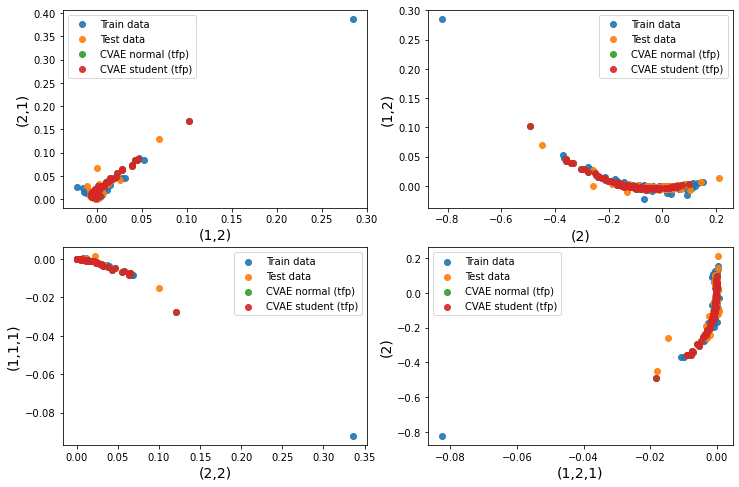

In [18]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

factor = []
for i in keys:
    factor.append((np.ceil((len(i)-2)/2)))
factor = np.array(factor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

# set_sig = [train_sig, test_sig, generated_sig, generated_sig1, generated_sig2]
# set_name = ["Train data", "Test data", "CVAE normal (keras)", "CVAE normal (tfp)", "CVAE student (tfp)"]

set_sig = [train_sig, test_sig, generated_sig2, generated_sig2]
set_name = ["Train data", "Test data", "CVAE normal (tfp)", "CVAE student (tfp)"]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)
    for j, signame in enumerate(zip(set_sig, set_name)):
        sig, name = signame
        plt.scatter(sig[:, projection[0]], sig[:, projection[1]],label=name, alpha = 0.9)
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
    
plt.show()

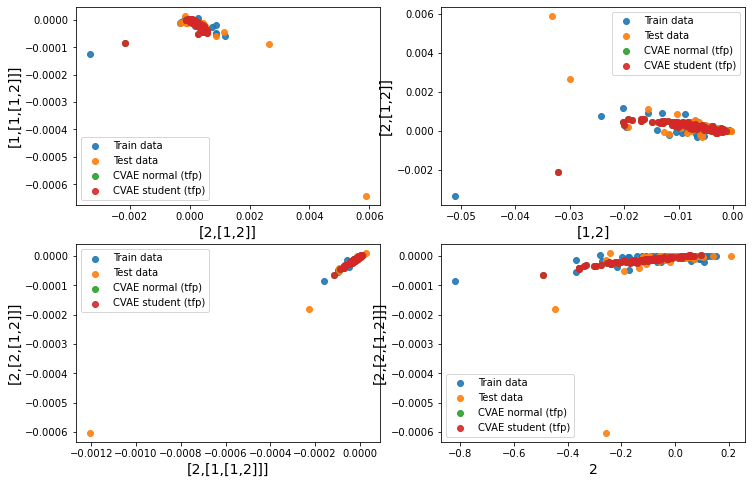

In [20]:
from esig.tosig import logsigkeys
import re

logkeys = logsigkeys(2, order).split()

logfactor = []
for i in logkeys:
    logfactor.append((len(re.sub("\D", "", i))))
logfactor = np.array(logfactor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (1, 7)]

set_logsig = [train_logsig, test_logsig, generated_logsig2, generated_logsig2]
set_name = ["Train data", "Test data", "CVAE normal (tfp)", "CVAE student (tfp)"]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i+1)
    for sig, name in zip(set_logsig, set_name):
        plt.scatter(sig[:, projection[0]], sig[:, projection[1]],label=name, alpha = 0.9)
        
    plt.xlabel(logkeys[projection[0]], fontsize=14)
    plt.ylabel(logkeys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
plt.show()

## Compared with keras and tfp

In [ ]:
# #CVAE_keras
# generator = cvae_keras.CVAE(n_latent=8, n_hidden = 50, alpha=0.003)
# generator.build(data.shape[-1], data_cond.shape[-1])
# generator.train(data, data_cond, n_epochs=10000)

# normalised_generated = np.array([generator.generate(cond)[0] for cond in data_cond])
# generated_logsig = scaler.inverse_transform(normalised_generated)
# generated_sig = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig)])

In [ ]:
# # Standard normal (tfp)
# reload(cvae_tfp)
# sample_dim = data.shape[0]
# data_dim = data.shape[-1]
# cond_dim = data_cond.shape[-1]
# latent_dim = 8
# hidden_dim = 50
# weight = 0.003

# x_input = [data, data_cond]
# encoder = cvae_tfp.Encoder(data_dim, cond_dim, latent_dim, hidden_dim)
# sampler = cvae_tfp.NormalSampler(latent_dim)
# encodersampler = cvae_tfp.EncoderSampler(encoder,sampler)
# decoder = cvae_tfp.Decoder(data_dim, cond_dim, latent_dim, hidden_dim)
# model_normal = cvae_tfp.CVAE_bergomi(data_dim, cond_dim, latent_dim, hidden_dim, weight, decoder, encodersampler)
# model_normal.compile(optimizer='adam', loss=cvae_tfp.zero_error)
# model_normal.fit(x = x_input, y = data, epochs=10000,batch_size=sample_dim, verbose = True)

# normalised_generated1 = model_normal.generate(data_cond)
# generated_logsig1 = scaler.inverse_transform(normalised_generated1)
# generated_sig1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig1)])

# # generated_sig1 = scaler.inverse_transform(normalised_generated1)
# # generated_logsig1 = np.array([tosig.sig2logsig(sig, 2, order) for sig in tqdm(generated_sig1)])

In [16]:
# mn, sd, z = generator.encoder([data, data_cond])
# x = generator.decoder([z, data_cond])

# data_torch = torch.tensor(data, dtype = torch.float)
# data_cond_torch = torch.tensor(data_cond, dtype = torch.float)
# x_torch = torch.tensor(x.numpy(), dtype = torch.float)
# mn_torch = torch.tensor(mn.numpy(), dtype = torch.float)
# sd_torch = torch.tensor(sd.numpy(), dtype = torch.float)

# loss = model.calculate_loss(data_torch, x_torch, mn_torch, sd_torch)
# loss/999

# model.eval()
# with torch.no_grad():
#     reconstructed_x, z_mu, z_var = model(data_torch, data_cond_torch)
#     loss = model.calculate_loss(data_torch, reconstructed_x, z_mu, z_var)
# loss/999

tensor(0.0105)

## Circle Data

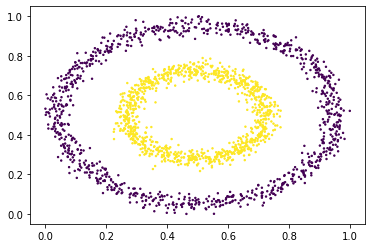

In [21]:
reload(cvae_torch)
BATCH_SIZE = 64         # number of data points in each batch
INPUT_DIM = 2     # size of each input
HIDDEN_DIM = 50        # hidden dimension   50
LATENT_DIM = 4         # latent vector dimension   8
CONDITION_DIM = 1      # condition dim
BETA = 0.02

data, data_cond = make_circles(n_samples=2000, noise=0.05, factor=0.5)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data_cond = data_cond.reshape(-1, 1)
# Plot dataset
plt.scatter(*data.T, c=data_cond, s=2)
plt.show()

In [22]:
train_iterator, test_iterator = cvae_torch.data_pepare(data,data_cond,1000, BATCH_SIZE)
model = cvae_torch.CVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, CONDITION_DIM, BETA)
model.prepare(train_iterator, test_iterator)

In [23]:
model.train_all(1000)

Epoch 0, Train Loss: 2.01999, Test Loss: 2.06628
Epoch 1, Train Loss: 1.95281, Test Loss: 2.01009
Epoch 2, Train Loss: 1.92680, Test Loss: 2.01645
Epoch 3, Train Loss: 1.92955, Test Loss: 2.00865
Epoch 4, Train Loss: 1.92311, Test Loss: 1.98434
Epoch 5, Train Loss: 1.91965, Test Loss: 1.97148
Epoch 6, Train Loss: 1.89255, Test Loss: 1.96152
Epoch 7, Train Loss: 1.86944, Test Loss: 1.95468
Epoch 8, Train Loss: 1.82147, Test Loss: 1.88431
Epoch 9, Train Loss: 1.78524, Test Loss: 1.80842
Epoch 10, Train Loss: 1.73382, Test Loss: 1.75304
Epoch 11, Train Loss: 1.60670, Test Loss: 1.69758
Epoch 12, Train Loss: 1.50691, Test Loss: 1.61415
Epoch 13, Train Loss: 1.42189, Test Loss: 1.52811
Epoch 14, Train Loss: 1.43248, Test Loss: 1.45175
Epoch 15, Train Loss: 1.33148, Test Loss: 1.39028
Epoch 16, Train Loss: 1.26921, Test Loss: 1.34145
Epoch 17, Train Loss: 1.25723, Test Loss: 1.22614
Epoch 18, Train Loss: 1.20277, Test Loss: 1.19749
Epoch 19, Train Loss: 1.20462, Test Loss: 1.22662
Epoch 20, 

Epoch 163, Train Loss: 0.81918, Test Loss: 0.84192
Epoch 164, Train Loss: 0.79022, Test Loss: 0.83026
Epoch 165, Train Loss: 0.83656, Test Loss: 0.81871
Epoch 166, Train Loss: 0.81049, Test Loss: 0.83089
Epoch 167, Train Loss: 0.84150, Test Loss: 0.85206
Epoch 168, Train Loss: 0.80348, Test Loss: 0.81904
Epoch 169, Train Loss: 0.79958, Test Loss: 0.81040
Epoch 170, Train Loss: 0.78889, Test Loss: 0.82548
Epoch 171, Train Loss: 0.82199, Test Loss: 0.81175
Epoch 172, Train Loss: 0.80498, Test Loss: 0.82058
Epoch 173, Train Loss: 0.81448, Test Loss: 0.84558
Epoch 174, Train Loss: 0.81781, Test Loss: 0.83638
Epoch 175, Train Loss: 0.81551, Test Loss: 0.82490
Epoch 176, Train Loss: 0.83354, Test Loss: 0.81360
Epoch 177, Train Loss: 0.79628, Test Loss: 0.84284
Epoch 178, Train Loss: 0.80242, Test Loss: 0.83496
Epoch 179, Train Loss: 0.82100, Test Loss: 0.80640
Epoch 180, Train Loss: 0.79375, Test Loss: 0.82321
Epoch 181, Train Loss: 0.78518, Test Loss: 0.79893
Epoch 182, Train Loss: 0.78718,

Epoch 326, Train Loss: 0.76689, Test Loss: 0.78218
Epoch 327, Train Loss: 0.75847, Test Loss: 0.76716
Epoch 328, Train Loss: 0.76606, Test Loss: 0.76921
Epoch 329, Train Loss: 0.76070, Test Loss: 0.78083
Epoch 330, Train Loss: 0.74228, Test Loss: 0.77407
Epoch 331, Train Loss: 0.76336, Test Loss: 0.75302
Epoch 332, Train Loss: 0.74513, Test Loss: 0.79297
Epoch 333, Train Loss: 0.73056, Test Loss: 0.78972
Epoch 334, Train Loss: 0.76411, Test Loss: 0.78250
Epoch 335, Train Loss: 0.74789, Test Loss: 0.78143
Epoch 336, Train Loss: 0.76767, Test Loss: 0.75012
Epoch 337, Train Loss: 0.75024, Test Loss: 0.79319
Epoch 338, Train Loss: 0.76531, Test Loss: 0.76762
Epoch 339, Train Loss: 0.75694, Test Loss: 0.77560
Epoch 340, Train Loss: 0.75926, Test Loss: 0.76937
Epoch 341, Train Loss: 0.76239, Test Loss: 0.77236
Epoch 342, Train Loss: 0.74995, Test Loss: 0.76240
Epoch 343, Train Loss: 0.74564, Test Loss: 0.76933
Epoch 344, Train Loss: 0.74602, Test Loss: 0.77665
Epoch 345, Train Loss: 0.76967,

Epoch 491, Train Loss: 0.74373, Test Loss: 0.75047
Epoch 492, Train Loss: 0.73684, Test Loss: 0.77255
Epoch 493, Train Loss: 0.71703, Test Loss: 0.74283
Epoch 494, Train Loss: 0.73614, Test Loss: 0.74571
Epoch 495, Train Loss: 0.73935, Test Loss: 0.76211
Epoch 496, Train Loss: 0.72854, Test Loss: 0.75950
Epoch 497, Train Loss: 0.72543, Test Loss: 0.76173
Epoch 498, Train Loss: 0.74820, Test Loss: 0.79190
Epoch 499, Train Loss: 0.74514, Test Loss: 0.78463
Epoch 500, Train Loss: 0.75100, Test Loss: 0.75516
Epoch 501, Train Loss: 0.74552, Test Loss: 0.77664
Epoch 502, Train Loss: 0.74738, Test Loss: 0.77223
Epoch 503, Train Loss: 0.73110, Test Loss: 0.76177
Epoch 504, Train Loss: 0.75375, Test Loss: 0.77390
Epoch 505, Train Loss: 0.75061, Test Loss: 0.75641
Epoch 506, Train Loss: 0.72406, Test Loss: 0.76183
Epoch 507, Train Loss: 0.74043, Test Loss: 0.74445
Epoch 508, Train Loss: 0.74531, Test Loss: 0.76498
Epoch 509, Train Loss: 0.75434, Test Loss: 0.75713
Epoch 510, Train Loss: 0.71294,

Epoch 656, Train Loss: 0.74411, Test Loss: 0.75331
Epoch 657, Train Loss: 0.72732, Test Loss: 0.75659
Epoch 658, Train Loss: 0.73532, Test Loss: 0.75355
Epoch 659, Train Loss: 0.73640, Test Loss: 0.74894
Epoch 660, Train Loss: 0.73819, Test Loss: 0.75637
Epoch 661, Train Loss: 0.76065, Test Loss: 0.76490
Epoch 662, Train Loss: 0.74157, Test Loss: 0.73986
Epoch 663, Train Loss: 0.73341, Test Loss: 0.74238
Epoch 664, Train Loss: 0.74190, Test Loss: 0.76099
Epoch 665, Train Loss: 0.74451, Test Loss: 0.77250
Epoch 666, Train Loss: 0.73751, Test Loss: 0.75170
Epoch 667, Train Loss: 0.73891, Test Loss: 0.76260
Epoch 668, Train Loss: 0.74034, Test Loss: 0.76857
Epoch 669, Train Loss: 0.73930, Test Loss: 0.75116
Epoch 670, Train Loss: 0.73579, Test Loss: 0.75716
Epoch 671, Train Loss: 0.71663, Test Loss: 0.75450
Epoch 672, Train Loss: 0.75400, Test Loss: 0.75846
Epoch 673, Train Loss: 0.73718, Test Loss: 0.74125
Epoch 674, Train Loss: 0.73337, Test Loss: 0.76599
Epoch 675, Train Loss: 0.73636,

Epoch 820, Train Loss: 0.73678, Test Loss: 0.74061
Epoch 821, Train Loss: 0.73378, Test Loss: 0.74129
Epoch 822, Train Loss: 0.72502, Test Loss: 0.73753
Epoch 823, Train Loss: 0.73617, Test Loss: 0.75025
Epoch 824, Train Loss: 0.71732, Test Loss: 0.75760
Epoch 825, Train Loss: 0.73471, Test Loss: 0.74144
Epoch 826, Train Loss: 0.72163, Test Loss: 0.72531
Epoch 827, Train Loss: 0.72397, Test Loss: 0.74025
Epoch 828, Train Loss: 0.73017, Test Loss: 0.75859
Epoch 829, Train Loss: 0.73279, Test Loss: 0.75075
Epoch 830, Train Loss: 0.73066, Test Loss: 0.75775
Epoch 831, Train Loss: 0.73500, Test Loss: 0.74442
Epoch 832, Train Loss: 0.72634, Test Loss: 0.73880
Epoch 833, Train Loss: 0.76100, Test Loss: 0.75891
Epoch 834, Train Loss: 0.73721, Test Loss: 0.74355
Epoch 835, Train Loss: 0.73719, Test Loss: 0.75274
Epoch 836, Train Loss: 0.75216, Test Loss: 0.75829
Epoch 837, Train Loss: 0.73451, Test Loss: 0.73278
Epoch 838, Train Loss: 0.70676, Test Loss: 0.74154
Epoch 839, Train Loss: 0.73682,

Epoch 984, Train Loss: 0.73001, Test Loss: 0.73314
Epoch 985, Train Loss: 0.72224, Test Loss: 0.74036
Epoch 986, Train Loss: 0.71780, Test Loss: 0.74297
Epoch 987, Train Loss: 0.74191, Test Loss: 0.75418
Epoch 988, Train Loss: 0.72995, Test Loss: 0.75917
Epoch 989, Train Loss: 0.73257, Test Loss: 0.74890
Epoch 990, Train Loss: 0.72555, Test Loss: 0.74890
Epoch 991, Train Loss: 0.73501, Test Loss: 0.74748
Epoch 992, Train Loss: 0.75998, Test Loss: 0.75633
Epoch 993, Train Loss: 0.71717, Test Loss: 0.74026
Epoch 994, Train Loss: 0.74243, Test Loss: 0.76022
Epoch 995, Train Loss: 0.70863, Test Loss: 0.75637
Epoch 996, Train Loss: 0.74879, Test Loss: 0.75191
Epoch 997, Train Loss: 0.71956, Test Loss: 0.74394
Epoch 998, Train Loss: 0.72012, Test Loss: 0.73416
Epoch 999, Train Loss: 0.72209, Test Loss: 0.73639


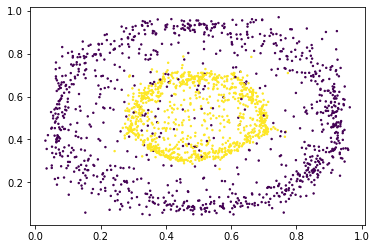

In [26]:
cond = torch.randint(0, 2, (2000, 1)).to(dtype=torch.long)
points = model.generate(cond)
plt.figure()
plt.scatter(*points.T, c=cond, s=2)
plt.show()